In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from scipy.stats import norm
from random import random as rnd
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import copy
import scipy
import math
import pickle
import random
import time
import itertools

%matplotlib inline

### Função para calcular salvar e carregar objetos

In [2]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as fp:
        file = pickle.load(fp)

### Função para calcular erro de predição

In [487]:
def nrmse(m, ano_eleicao, votacao, df, metric):
    list_of_series = [x.up_result for x in m.space]
    list_of_ids = [x.unique_id for x in m.space]
    cols = m.space[0].up_result.index

    series = pd.DataFrame(list_of_series, columns=cols)
    ids = pd.DataFrame(list_of_ids, columns=['unique_id'])

    prev = pd.concat([ids,series], axis=1)

    if metric=='nrmse':
        df_next = votacao[votacao['ano']==ano_eleicao+4]
        df_next = df_next.drop(['ano', 'votos'], axis=1)
        prev = mse(df_next, prev) / mse(df_next, df)
    elif metric=='rmse':
        df_next = votacao[votacao['ano']==ano_eleicao+4]
        df_next = df_next.drop(['ano', 'votos'], axis=1)
        prev = np.sqrt(mse(df_next, prev))
    elif metric=='rmse_g4':
        df_next = votacao[votacao['ano']==ano_eleicao+4]
        df_next = df_next.drop(['ano', 'votos'], axis=1)
        df_mean = df_next.drop(['unique_id'], axis=1)
        df_mean.iloc[:,:] = df.iloc[:,1:].values.flatten().mean()
        df_rnd = np.array([np.random.dirichlet(np.ones(35),size=1)[0] for x in range(6038)])
        prev = [np.sqrt(mse(df_next, prev)),
                np.sqrt(mse(df_next, df)),
                np.sqrt(mse(df_next.iloc[:,1:], df_mean)),
                np.sqrt(mse(df_next.iloc[:,1:], df_rnd))]
    elif metric=='rmse_g8':
        df_next = votacao[votacao['ano']==ano_eleicao+8]
        df_next = df_next.drop(['ano', 'votos'], axis=1)
        df_mean = df_next.drop(['unique_id'], axis=1)
        df_mean.iloc[:,:] = df.iloc[:,1:].values.flatten().mean()
        df_rnd = np.array([np.random.dirichlet(np.ones(35),size=1)[0] for x in range(6038)])
        prev = [np.sqrt(mse(df_next, prev)),
                np.sqrt(mse(df_next, df)),
                np.sqrt(mse(df_next.iloc[:,1:], df_mean)),
                np.sqrt(mse(df_next.iloc[:,1:], df_rnd))]
    elif metric=='rmse_g12':
        df_next = votacao[votacao['ano']==ano_eleicao+12]
        df_next = df_next.drop(['ano', 'votos'], axis=1)
        df_mean = df_next.drop(['unique_id'], axis=1)
        df_mean.iloc[:,:] = df.iloc[:,1:].values.flatten().mean()
        df_rnd = np.array([np.random.dirichlet(np.ones(35),size=1)[0] for x in range(6038)])
        prev = [np.sqrt(mse(df_next, prev)),
                np.sqrt(mse(df_next, df)),
                np.sqrt(mse(df_next.iloc[:,1:], df_mean)),
                np.sqrt(mse(df_next.iloc[:,1:], df_rnd))]
    else:
        prev = 0
    
    return prev

### Função para calcular R2 ajustado

In [4]:
def r2_adj(y_true, y_pred, n, p):
    r2_score = r2(y_true, y_pred)
    return 1 - ((1 - r2_score)*((n-1)/(n-p-1)))

### Importa arquivo de metadados das cidades_zonas

In [5]:
cidade_zona = pd.read_csv("./working_data/cidade_zona.csv", sep=",")

In [8]:
## Cria chave única
## Descrição: primeiro dígito é 1 se é uma zona, 2 se cidade.
cidade_zona['unique_id'] = np.where(cidade_zona['cidade_b']==1, \
                                    (cidade_zona['cod_cidade'] + cidade_zona['cidade_b']*2000000), \
                                    cidade_zona['numero_zona'])

In [9]:
chave = cidade_zona.loc[:,('unique_id', 'cod_cidade', 'numero_zona')]

In [10]:
cidade_zona = cidade_zona.loc[:,('unique_id', 'lat', 'lng')]

### Importa arquivo de distâncias entre cidades

In [13]:
with open('./working_data/cidade_zona_list.pkl', 'rb') as fp:
    cidade_zona_list = pickle.load(fp)

### Importa arquivo com os vizinhos

In [15]:
with open('./working_data/cidade_zona_nb.pkl', 'rb') as fp:
    cidade_zona_nb = pickle.load(fp)

### Importa arquivo de votação por cidade_zona e eleição

In [17]:
votacao = pd.read_csv("./working_data/votacao.csv", sep=",")

In [18]:
votacao = pd.merge(chave, votacao, on=("cod_cidade", "numero_zona"))
votacao = votacao.drop(['cod_cidade'], axis=1)
votacao = votacao.drop(['numero_zona'], axis=1)

### Cria vetor com volumes por unique_id
O volume é baseado no número médio de votantes daquela cidade_zona através de todas as eleições que houveram lá.

In [21]:
volume = votacao.groupby(['unique_id'])['votos'].mean()

In [22]:
volume = (volume - min(volume) + 1e-6) / max(volume)

### Cria modelo para simulação multi-agente

In [24]:
class Model():
    def __init__(self, N):
        self.num_agents = N
        self.space = [None] * N
        self.chave = [None] * N
        self.index = 0
        
    def place_agent(self,a):
        self.space[self.index] = a
        self.chave[self.index] = [self.index, a.unique_id]
        self.index += 1
        
    def get_weights(self):  
        for i in range(len(self.space)):
            ## Tratamendo dado a cada agente
            n = self.space[i].neighbors.shape[0]
            weights = np.zeros(n)
            n_idx_list = [None] * n
            for j in range(n):
                n_id = self.space[i].neighbors.index[j]
                n_idx = next((i for i, x in enumerate(self.space) if x.unique_id == int(n_id)), None)
                n_idx_list[j] = n_idx
                distance = self.space[i].neighbors[j] + 1.0
                volume = self.space[n_idx].volume
                #weight = kappa * (math.exp(-distance/alpha)) + (1 - kappa) * (beta * volume)
                weight = (self.space[n_idx].volume) / (np.log10(distance))
                weights[j] = weight
            weights = weights/sum(weights)
            self.space[i].weights = pd.Series(weights, index=self.space[i].neighbors.index)
            self.space[i].neighbors_address = n_idx_list
            
    def get_nb_result(self, a):
        nb_idx = self.space[a].neighbors.index
        nb_id = self.space[a].neighbors_address
        weights = self.space[a].weights 
        result = np.zeros(self.space[a].result.shape[0])
        for i in range(self.space[a].weights.shape[0]):
                weight_update = self.space[nb_id[i]].result.values * weights.at[nb_idx[i]]
                result = result + weight_update  
        return result
        
    def iterate(self, alpha=1/2, beta=1/2, gamma=5e-3, d_norm=1e-3):        
        for a in range(len(self.space)):
            ## Para cada agente 'a' 
            result = self.get_nb_result(a)
            self.space[a].step(result, alpha, beta, gamma, d_norm)
    
    def update_votes(self):
        for i in range(len(self.space)):
            self.space[i].result = self.space[i].up_result     

In [25]:
class Agent():
    def __init__(self, unique_id, coordinates, neighbors, result, volume):
        self.unique_id = unique_id
        self.coordinates = coordinates
        self.volume = volume
        self.neighbors = neighbors
        self.neighbors_address = None
        self.weights = None
        self.initial = result
        self.result = result
        self.up_result = result
        
    def _step(self, nb_result, gamma1, gamma2):
        result = ((gamma1 * rnd()) * nb_result) + (gamma2 * rnd()) + self.result.values
        result = result / sum(result)
        self.up_result = pd.Series(result, index=self.up_result.index)
        
    def step(self, nb_result, alpha, beta, gamma, d_norm):
        epsilon = 1e-6
        v = self.result.values
        r = alpha*v + (1-alpha)*nb_result
        d = np.random.dirichlet((v+epsilon)/d_norm).transpose()
        f = np.ones(v.shape[0])*(1/v.shape[0])
        p = (1-beta-gamma)*r + beta*d + gamma*f
        self.up_result = pd.Series((p/sum(p)), index=self.up_result.index)
        

### Cria função para executar um modelo

In [27]:
def single_run(m, ano_eleicao, votacao, num_iter, alpha, beta, gamma, d_norm, metric):
    df = votacao[votacao['ano']==ano_eleicao]
    df = df.drop(['ano', 'votos'], axis=1)
    df.index = range(df.shape[0])

    nrmse_vec = [None] * (num_iter+1)
    for i in range(num_iter):
        m.iterate(alpha, beta, gamma, d_norm)
        nrmse_vec[i] = nrmse(m, ano_eleicao, votacao, df, metric)
        m.update_votes()
    nrmse_vec[i+1] = m
        
    return nrmse_vec

### Modelo-base para análise

In [313]:
ano_eleicao = 2006

df = votacao[votacao['ano']==ano_eleicao]
df = df.drop(['ano', 'votos'], axis=1)
df.index = range(df.shape[0])

m = Model(df.shape[0])
for i in range(df.shape[0]):
    unique_id = df.loc[i, 'unique_id']
    a = Agent(unique_id,
              cidade_zona[cidade_zona['unique_id']== \
                          df.loc[i, 'unique_id']].loc[:,('lat', 'lng')].values[0],
              cidade_zona_nb[[row[0] for row in cidade_zona_nb].index(str(unique_id))][1],
              df.iloc[i, 1:36],
              volume.at[df.loc[i, 'unique_id']])
    m.place_agent(a)

m.get_weights()

save_object(m, "./working_data/model_base_2014.pkl")

In [28]:
file_m_sample = open('./working_data/model_base_2006.pkl', 'rb')
m_06 = pickle.load(file_m_sample)

In [312]:
file_m_sample = open('./working_data/model_base_2010.pkl', 'rb')
m_10 = pickle.load(file_m_sample)

In [314]:
file_m_sample = open('./working_data/model_base_2014.pkl', 'rb')
m_14 = pickle.load(file_m_sample)

### Baseline

In [485]:
ano_eleicao = 2006

In [515]:
#p = results_25111801[5]
#single_run(m, ano_eleicao, votacao, max_iter, alpha, beta, gamma, d_norm, 'rmse')
m = copy.deepcopy(m_14)
r = single_run(m, ano_eleicao, votacao, 3, 0.5, 0.5-0.05, 0.05, 1e-3, 'rmse_g4')

### Gráfico: Evolução da distribuição de votos por partido
Nesse gráfico estão a média por desvio-padrão de todos os partidos nas eleições de 2006 a 2018

In [47]:
# 
df = votacao.drop(['votos', 'unique_id'], axis=1)
df_mean = df.groupby(['ano'], as_index=True).mean().transpose().stack()
df_std = df.groupby(['ano'], as_index=True).std().transpose().stack()
df = pd.DataFrame([df_mean, df_std]).transpose()
df.reset_index(inplace=True)
df.columns = ['partido', 'ano', 'mean', 'std']

current_palette = sns.color_palette()
x = np.linspace(0, 0.2, 100)

q_2006 = np.polyfit(df[df['ano']==2006]['mean'].values, df[df['ano']==2006]['std'].values, 2)
y_2006 = np.poly1d(q_2006)(x)
q_2010 = np.polyfit(df[df['ano']==2010]['mean'].values, df[df['ano']==2010]['std'].values, 2)
y_2010 = np.poly1d(q_2010)(x)
q_2014 = np.polyfit(df[df['ano']==2014]['mean'].values, df[df['ano']==2014]['std'].values, 2)
y_2014 = np.poly1d(q_2014)(x)
q_2018 = np.polyfit(df[df['ano']==2018]['mean'].values, df[df['ano']==2018]['std'].values, 2)
y_2018 = np.poly1d(q_2018)(x)

In [49]:
q_mean = df[df['ano']==2006]['mean'].values
q_std = df[df['ano']==2006]['std'].values
print(r2_adj(q_std, np.poly1d(q_2006)(q_mean), q_std.shape[0], 2))

q_mean = df[df['ano']==2010]['mean'].values
q_std = df[df['ano']==2010]['std'].values
print(r2_adj(q_std, np.poly1d(q_2010)(q_mean), q_std.shape[0], 2))

q_mean = df[df['ano']==2014]['mean'].values
q_std = df[df['ano']==2014]['std'].values
print(r2_adj(q_std, np.poly1d(q_2014)(q_mean), q_std.shape[0], 2))

q_mean = df[df['ano']==2018]['mean'].values
q_std = df[df['ano']==2018]['std'].values
print(r2_adj(q_std, np.poly1d(q_2018)(q_mean), q_std.shape[0], 2))

0.9480084816823103
0.9613344886062953
0.9675730621508765
0.9634428227150656


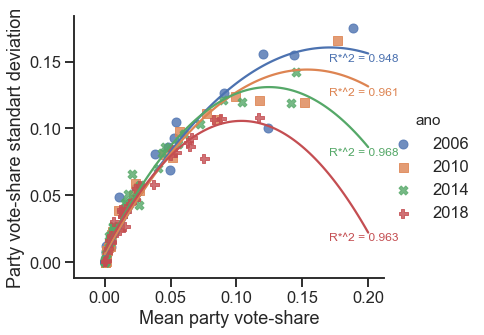

In [276]:
sns.set_context('talk')
s = sns.lmplot('mean', 'std', data=df, hue='ano', markers=["o", "s", "X", "P"], 
               order=2, truncate=True, aspect=1.2, fit_reg=False, ci=None)
plt.plot(x, y_2006, color=current_palette[0])
plt.text(0.17, 0.15, "R*^2 = 0.948", fontsize=12, color=current_palette[0])
plt.plot(x, y_2010, color=current_palette[1])
plt.text(0.17, 0.125, "R*^2 = 0.961", fontsize=12, color=current_palette[1])
plt.plot(x, y_2014, color=current_palette[2])
plt.text(0.17, 0.08, "R*^2 = 0.968", fontsize=12, color=current_palette[2])
plt.plot(x, y_2018, color=current_palette[3])
plt.text(0.17, 0.016, "R*^2 = 0.963", fontsize=12, color=current_palette[3])
s.set(xlabel='Mean party vote-share', ylabel='Party vote-share standart deviation')
plt.show()

In [277]:
s.savefig("./working_data/evolucao_quadratica.png", dpi=400)

### Results 01: Definir o número de iterações

In [135]:
randomize_grid = {
    'alpha': [0.3, 0.4, 0.5, 0.6, 0.7],
    'beta': [0.3, 0.4, 0.5, 0.6, 0.7],
    'gamma': [0.0, 1e-3, 3e-3, 5e-3, 1e-2, 2e-2],
    'd_norm': [5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
}

In [517]:
n = 50
run = 10
max_iter = 15
np.random.seed(1)

In [518]:
nrmse_vec_v = [None]*run
results = [None]*n

In [519]:
for it in range(n):
    
    st = time.time()    
    
    ## Realiza 'run' repetidas execuções para cada tupla do grid
    ## Para cada execução, roda até 'max_iter' ciclos de atualização de vetor vote-share
    for check in range(run):
        m = copy.deepcopy(m_06)
        alpha, beta, gamma, d_norm = [random.choice(x[1]) for x in list(randomize_grid.items())]
        nrmse_vec_v[check] = single_run(m, ano_eleicao, votacao, max_iter, alpha, beta, gamma, d_norm, 'rmse')
    
    ## Calcula o RMSE
    rmse_vec = np.mean([x[:-1] for x in nrmse_vec_v], axis=0)
    results[it] = [alpha, beta, gamma, d_norm, rmse_vec]
    print("it: ", it, ", Demorou: ", time.time()-st, ", Resultado: ", min(results[it][-1]), 
          ", Ciclo: ", np.argmin(results[it][-1]))

it:  0 , Demorou:  259.59777641296387 , Resultado:  0.06075641522959432 , Ciclo:  0
it:  1 , Demorou:  260.73862743377686 , Resultado:  0.05880671690434308 , Ciclo:  1
it:  2 , Demorou:  259.39477467536926 , Resultado:  0.05755976857670928 , Ciclo:  2
it:  3 , Demorou:  264.6595256328583 , Resultado:  0.05905893272570981 , Ciclo:  2
it:  4 , Demorou:  262.83346724510193 , Resultado:  0.05772774658489797 , Ciclo:  2
it:  5 , Demorou:  265.6900362968445 , Resultado:  0.05870488152464602 , Ciclo:  1
it:  6 , Demorou:  264.3487846851349 , Resultado:  0.05673431648756984 , Ciclo:  2
it:  7 , Demorou:  264.09670400619507 , Resultado:  0.05778660571329438 , Ciclo:  2
it:  8 , Demorou:  267.8791620731354 , Resultado:  0.05951083156090792 , Ciclo:  2
it:  9 , Demorou:  265.2213878631592 , Resultado:  0.05912411514765894 , Ciclo:  1
it:  10 , Demorou:  268.0510597229004 , Resultado:  0.05879733957696191 , Ciclo:  2
it:  11 , Demorou:  265.51828479766846 , Resultado:  0.058956681144797005 , Ciclo

In [525]:
resultado_iteracao = pd.DataFrame([np.argmin(x[-1] + 1) for x in results])
resultado_iteracao.columns = ["count"]

In [531]:
resultado_iteracao['count'] = resultado_iteracao['count'] + 1

[Text(0,0.5,'Count'), Text(0.5,0,'Number of cycles')]

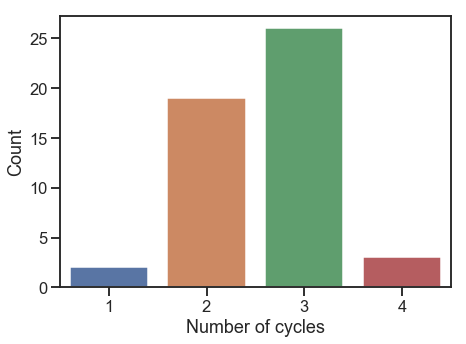

In [532]:
fig, ax = plt.subplots(figsize=(7,5))
sns.set(style="ticks")
sns.set_context('talk')
ax = sns.countplot(x='count', data=resultado_iteracao)
ax.set(xlabel='Number of cycles', ylabel='Count')
#plt.show()

In [523]:
save_object(results, "./working_data/results_num_iter.pkl")

In [533]:
fig.savefig("./working_data/number_of_iterations.png", dpi=400)

### Results 02: Gera busca exaustiva para o D e Gamma

In [230]:
grid = {
    'alpha': [0.5],
    'beta': [0.5],
    'gamma': [0.0, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'd_norm': [1e-6, 1e-4, 5e-4, 1e-3, 5e-3, 5e-2]
}

In [231]:
allNames = sorted(grid)
grid = itertools.product(*(grid[Name] for Name in allNames))
grid = list(grid)
np.random.seed(1)
n = len(grid)
run = 3
results = [None]*n

In [232]:
for it in range(n):
    st = time.time()
    nrmse_vec_v = [None]*run
    for check in range(run):
        m = copy.deepcopy(m_06)
        nrmse_vec_v[check] = single_run(m, ano_eleicao, votacao, 3, 
                                        grid[it][0], 0.5-grid[it][3], grid[it][3], grid[it][2], 'rmse')
        if check==0:
            m_result = pd.DataFrame([x.result for x in m.space])
        else:
            m_result = m_result + pd.DataFrame([x.result for x in m.space])
    m_result = m_result/run
    m_result = [m_result.mean().values, m_result.std().values]
    
    nrmse_vec = np.mean([x[:-1] for x in nrmse_vec_v], axis=0)
    results[it] = [grid[it][0], grid[it][1], grid[it][3], grid[it][2], m_result, nrmse_vec]
    print("it: ", it, ", Demorou: ", time.time()-st, ", Resultado: ", min(results[it][-1]), 
          ", Ciclo: ", np.argmin(results[it][-1]))

it:  0 , Demorou:  21.276284217834473 , Resultado:  0.05609456294346415 , Ciclo:  2
it:  1 , Demorou:  19.698561668395996 , Resultado:  0.05604492483689583 , Ciclo:  2
it:  2 , Demorou:  21.041929006576538 , Resultado:  0.055851132350675216 , Ciclo:  2
it:  3 , Demorou:  19.72980570793152 , Resultado:  0.05562749418413742 , Ciclo:  2
it:  4 , Demorou:  20.245275020599365 , Resultado:  0.054528981508014523 , Ciclo:  2
it:  5 , Demorou:  20.028722286224365 , Resultado:  0.05420343515058157 , Ciclo:  1
it:  6 , Demorou:  20.05781388282776 , Resultado:  0.056100888950310034 , Ciclo:  2
it:  7 , Demorou:  20.10468077659607 , Resultado:  0.05605184530468501 , Ciclo:  2
it:  8 , Demorou:  19.979759454727173 , Resultado:  0.05586194467898148 , Ciclo:  2
it:  9 , Demorou:  19.99536895751953 , Resultado:  0.05563796536839741 , Ciclo:  2
it:  10 , Demorou:  20.24527668952942 , Resultado:  0.05453516542895991 , Ciclo:  2
it:  11 , Demorou:  20.02653670310974 , Resultado:  0.054209892988764295 , Ci

In [234]:
r_rmse = pd.DataFrame([[x[2] for x in results], 
                       [x[3] for x in results], 
                       [x[5][-1] for x in results]]).transpose()
r_rmse.columns = ['gamma', 'd', 'rmse']

In [235]:
r_rmse.rmse = r_rmse.rmse*100

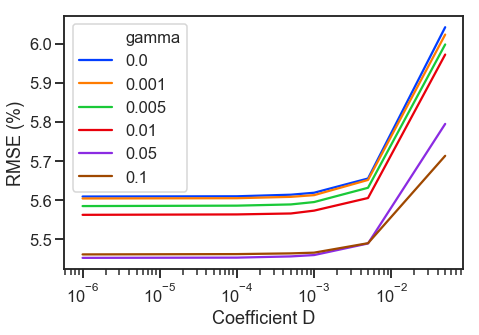

In [293]:
palette = sns.color_palette("bright", 6)
f, ax = plt.subplots(figsize=(7, 5))
sns.lineplot('d', 'rmse', data=r_rmse, hue='gamma', legend='full', palette=palette)
ax.set(xscale="log")
ax.set(xlabel='Coefficient D', ylabel='RMSE (%)')
plt.tight_layout()

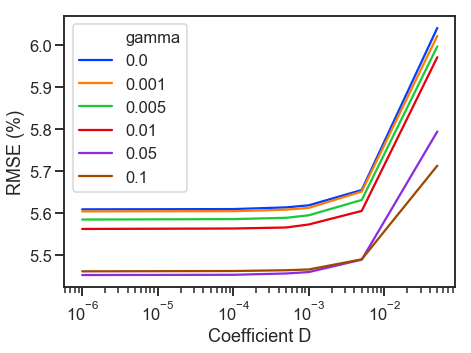

In [284]:
f

In [294]:
f.savefig("./working_data/d_gamma_grid_search.png", dpi=400)

### Results 03: Comportamento quadrático do modelo

In [241]:
##
r_k = 20
r_coeffs = pd.DataFrame([np.polyfit(x[4][0], x[4][1], 2) for x in results], columns=['a', 'b', 'c'])
r_parties = pd.DataFrame([results[r_k][4][0],results[r_k][4][1]]).transpose()
r_parties.columns=['mean', 'std']
x = np.linspace(0, 0.2, 100)
y = np.poly1d(r_coeffs.iloc[r_k].values)(x)

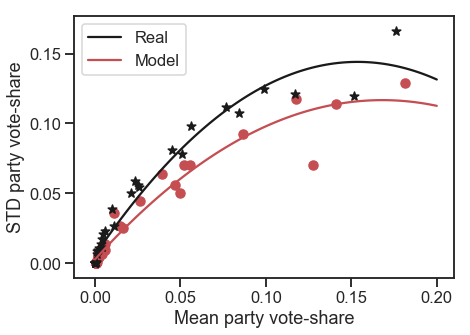

In [309]:
f, ax = plt.subplots(figsize=(7, 5))
p1 = plt.plot(x, y, color='r')
plt.scatter(r_parties['mean'].values, r_parties['std'].values, marker='o', color='r')
p2 = plt.plot(x, y_2010, color='k')
plt.scatter(df[df['ano']==2010]['mean'].values, df[df['ano']==2010]['std'].values, marker='*', color='k')
plt.xlabel('Mean party vote-share')
plt.ylabel('STD party vote-share')
plt.legend((p2[0], p1[0]), ('Real', 'Model'))
plt.tight_layout()

In [310]:
f.savefig("./working_data/quad_real_proj.png", dpi=400)

### Tabela de resultados para melhor set de variaveis

In [232]:
run = 5
st = time.time()
nrmse_vec_v = [None]*run

for check in range(run):
    m = copy.deepcopy(m_06)
    nrmse_vec_v[check] = single_run(m, ano_eleicao, votacao, 3, 
                                    0.5, 0.5-0.05, 0.05, 1e-3, 'rmse_g4')
    if check==0:
        m_result = pd.DataFrame([x.result for x in m.space])
    else:
        m_result = m_result + pd.DataFrame([x.result for x in m.space])
m_result = m_result/run
m_result = [m_result.mean().values, m_result.std().values]

nrmse_vec = np.mean([x[:-1] for x in nrmse_vec_v], axis=0)
results[it] = [grid[it][0], grid[it][1], grid[it][3], grid[it][2], m_result, nrmse_vec]
print("it: ", it, ", Demorou: ", time.time()-st, ", Resultado: ", min(results[it][-1]), 
      ", Ciclo: ", np.argmin(results[it][-1]))

it:  0 , Demorou:  21.276284217834473 , Resultado:  0.05609456294346415 , Ciclo:  2
it:  1 , Demorou:  19.698561668395996 , Resultado:  0.05604492483689583 , Ciclo:  2
it:  2 , Demorou:  21.041929006576538 , Resultado:  0.055851132350675216 , Ciclo:  2
it:  3 , Demorou:  19.72980570793152 , Resultado:  0.05562749418413742 , Ciclo:  2
it:  4 , Demorou:  20.245275020599365 , Resultado:  0.054528981508014523 , Ciclo:  2
it:  5 , Demorou:  20.028722286224365 , Resultado:  0.05420343515058157 , Ciclo:  1
it:  6 , Demorou:  20.05781388282776 , Resultado:  0.056100888950310034 , Ciclo:  2
it:  7 , Demorou:  20.10468077659607 , Resultado:  0.05605184530468501 , Ciclo:  2
it:  8 , Demorou:  19.979759454727173 , Resultado:  0.05586194467898148 , Ciclo:  2
it:  9 , Demorou:  19.99536895751953 , Resultado:  0.05563796536839741 , Ciclo:  2
it:  10 , Demorou:  20.24527668952942 , Resultado:  0.05453516542895991 , Ciclo:  2
it:  11 , Demorou:  20.02653670310974 , Resultado:  0.054209892988764295 , Ci

### Código para salvar e carregar modelos

In [ ]:
save_object(results, "./working_data/results_varying_d_g0.pkl")

In [ ]:
file_m_sample = open('./working_data/model_sample.pkl', 'rb')
m_sample = pickle.load(file_m_sample)